In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os


In [2]:
if not os.path.exists("data.pkl"):
    from ucimlrepo import fetch_ucirepo

    # fetch dataset
    secondary_mushroom = fetch_ucirepo(id=848)

    df = secondary_mushroom.data.features
    df = df.assign(target=secondary_mushroom.data.targets)
    with open("data.pkl", "wb") as f:
        pickle.dump(df, f)
else:
    with open("data.pkl", "rb") as f:
        df = pickle.load(f)
df["target"] = (df["target"] == "p").astype(int)

# Оценка данных

## Обработка данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          61069 non-null  float64
 1   cap-shape             61069 non-null  object 
 2   cap-surface           46949 non-null  object 
 3   cap-color             61069 non-null  object 
 4   does-bruise-or-bleed  61069 non-null  object 
 5   gill-attachment       51185 non-null  object 
 6   gill-spacing          36006 non-null  object 
 7   gill-color            61069 non-null  object 
 8   stem-height           61069 non-null  float64
 9   stem-width            61069 non-null  float64
 10  stem-root             9531 non-null   object 
 11  stem-surface          22945 non-null  object 
 12  stem-color            61069 non-null  object 
 13  veil-type             3177 non-null   object 
 14  veil-color            7413 non-null   object 
 15  has-ring           

In [4]:
real_features = ["cap-diameter", "stem-height", "stem-width"]
nullable_features = ["stem-root", "veil-type", "veil-color", "spore-print-color"]
cat_features = list(
    set(df.columns) - set(real_features) - set(["target"]) - set(nullable_features)
)


In [5]:
train, test = train_test_split(df, test_size=0.2)
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)


### Label Encoder

In [6]:
class OrderedLabelEncoder(LabelEncoder):
    def fit(self, X, y):
        X = super(OrderedLabelEncoder, self).fit_transform(X)
        
        classes = np.unique(X, return_counts=True)
        
        probs = [y[X == cl].sum()/cl_count for cl, cl_count in zip(*classes)]
        self.args = np.argsort(probs)
        return self
    
    def transform(self, X):
        X = super(OrderedLabelEncoder, self).transform(X)
        return self.args[X]
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

In [7]:
ole = OrderedLabelEncoder()
le = LabelEncoder()


ordere_lable_encoded_cat_features = []
lable_encoded_cat_features = []
for feat in cat_features:
    train[feat + "_OLE"] = ole.fit_transform(train[feat], train['target'])
    train[feat + "_LE"] = le.fit_transform(train[feat])

    test[feat + "_OLE"] = ole.transform(test[feat])
    test[feat + "_LE"] = le.transform(test[feat])
    lable_encoded_cat_features.append(feat + "_LE")
    ordere_lable_encoded_cat_features.append(feat + "_OLE")


In [8]:
train[lable_encoded_cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48855 entries, 0 to 48854
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   gill-spacing_LE          48855 non-null  int32
 1   season_LE                48855 non-null  int32
 2   ring-type_LE             48855 non-null  int32
 3   cap-color_LE             48855 non-null  int32
 4   gill-attachment_LE       48855 non-null  int32
 5   habitat_LE               48855 non-null  int32
 6   has-ring_LE              48855 non-null  int32
 7   stem-color_LE            48855 non-null  int32
 8   cap-surface_LE           48855 non-null  int32
 9   cap-shape_LE             48855 non-null  int32
 10  stem-surface_LE          48855 non-null  int32
 11  gill-color_LE            48855 non-null  int32
 12  does-bruise-or-bleed_LE  48855 non-null  int32
dtypes: int32(13)
memory usage: 2.4 MB


In [9]:
sns.heatmap(
    np.round(train[real_features + lable_encoded_cat_features + ["target"]].corr(), 1),
    annot=True,
)

### One Hot

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
train["gill-spacing"].unique()

array([nan, 'c', 'd', 'f'], dtype=object)

In [ ]:
ohe = OneHotEncoder(sparse_output=False, drop="first")
cols = ohe.fit_transform(train[cat_features])
ohe_columns_name = list(ohe.get_feature_names_out(cat_features))
train = pd.concat([train, pd.DataFrame(cols, columns=ohe_columns_name)], axis=1)

In [ ]:
pd.concat([train, pd.DataFrame(cols, columns=ohe_columns_name)], axis=1).shape[0] - train.shape[0]

0

In [ ]:
cols = ohe.transform(test[cat_features])
test = pd.concat([test, pd.DataFrame(cols, columns=ohe_columns_name)], axis=1)


<Axes: >

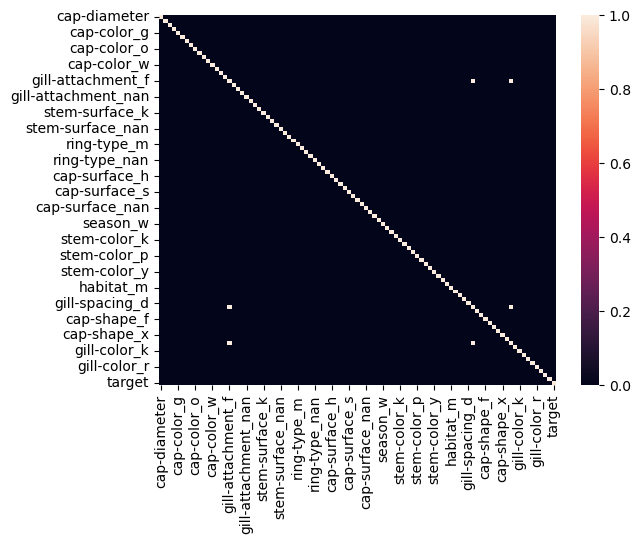

In [ ]:
sns.heatmap(
    train[real_features + ohe_columns_name + ["target"]].corr() > 0.75
)


In [ ]:
corrs = train[real_features + ohe_columns_name + ["target"]].corr()
corrs_without_diag = (corrs > 0.75) - np.eye(
    train[real_features + ohe_columns_name + ["target"]].shape[1]
)
inds = corrs_without_diag[(corrs_without_diag > 0).any()].index
corrs.loc[inds, inds]

ohe_columns_name.remove(inds[1])
ohe_columns_name.remove(inds[2])

<Axes: >

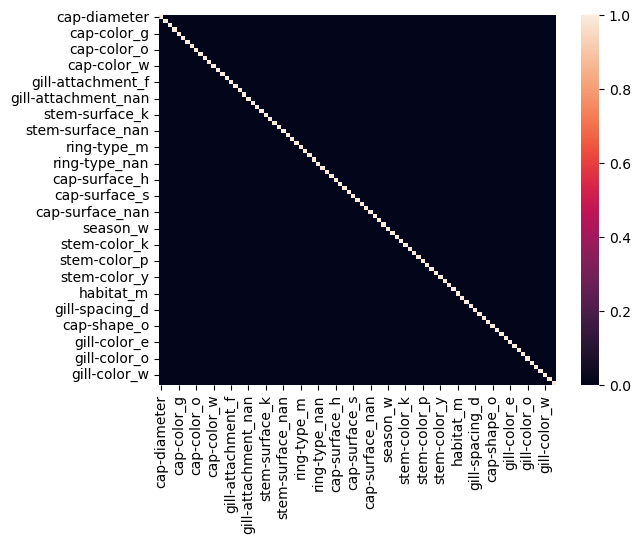

In [ ]:
sns.heatmap(train[real_features + ohe_columns_name + ["target"]].corr() > 0.75)

### Feature batched

In [ ]:
train[real_features[0]]

0         5.99
1         0.70
2         6.34
3        11.53
4         7.39
         ...  
48850     3.57
48851     8.26
48852     4.92
48853     4.75
48854     8.89
Name: cap-diameter, Length: 48855, dtype: float64

In [ ]:
one_rule_features = []
for feat in real_features:
    train[feat + "_mean"] = train[feat] > train[feat].mean()
    test[feat + "_mean"] = test[feat] > train[feat].mean()
    one_rule_features.append(feat + "_mean")
    quants = [0.25, 0.5, 0.75]
    _, bins = pd.qcut(train[feat], quants, retbins=True)
    for b, q in zip(bins, quants):
        train[feat + f"q_{q}"] = train[feat] > b
        test[feat + f"q_{q}"] = test[feat] > b
        one_rule_features.append(feat + f"q_{q}")

## Feature selection

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [ ]:
default_le_features = real_features + lable_encoded_cat_features
default_ohe_features = real_features + ohe_columns_name

In [ ]:
train[default_ohe_features]

,cap-diameter,stem-height,stem-width,cap-color_e,cap-color_g,cap-color_k,cap-color_l,cap-color_n,cap-color_o,cap-color_p,...,gill-color_e,gill-color_g,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y
0,5.99,8.16,9.59,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.70,3.43,0.96,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,6.34,8.24,11.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,11.53,11.04,21.03,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,7.39,7.83,17.28,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48850,3.57,5.29,10.25,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48851,8.26,11.49,27.09,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48852,4.92,7.08,9.11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
48853,4.75,8.11,8.41,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=5000).fit(
    train[default_ohe_features], train["target"]
)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.fit_transform(train[default_ohe_features])
linear_svc_based_features = model.get_feature_names_out()
print(linear_svc_based_features)

['cap-diameter' 'stem-height' 'stem-width' 'cap-color_e' 'cap-color_k'
 'cap-color_l' 'cap-color_n' 'cap-color_o' 'cap-color_p' 'cap-color_r'
 'cap-color_u' 'cap-color_w' 'gill-attachment_d' 'gill-attachment_e'
 'gill-attachment_f' 'gill-attachment_p' 'gill-attachment_s'
 'gill-attachment_x' 'gill-attachment_nan' 'stem-surface_g'
 'stem-surface_h' 'stem-surface_k' 'stem-surface_s' 'stem-surface_t'
 'stem-surface_y' 'stem-surface_nan' 'ring-type_f' 'ring-type_g'
 'ring-type_m' 'ring-type_p' 'ring-type_r' 'ring-type_z' 'ring-type_nan'
 'does-bruise-or-bleed_t' 'cap-surface_e' 'cap-surface_h' 'cap-surface_i'
 'cap-surface_k' 'cap-surface_l' 'cap-surface_s' 'cap-surface_t'
 'cap-surface_w' 'cap-surface_y' 'cap-surface_nan' 'has-ring_t' 'season_s'
 'season_u' 'season_w' 'stem-color_e' 'stem-color_f' 'stem-color_g'
 'stem-color_k' 'stem-color_l' 'stem-color_o' 'stem-color_p'
 'stem-color_u' 'stem-color_w' 'stem-color_y' 'habitat_g' 'habitat_h'
 'habitat_l' 'habitat_m' 'habitat_p' 'habitat_w'

In [ ]:
clf = ExtraTreesClassifier(n_estimators=100)
clf = clf.fit(train[default_le_features], train["target"])
print(clf.feature_importances_)
model = SelectFromModel(clf, prefit=True)
X_new = model.fit_transform(train[default_le_features])
tree_based_features = model.get_feature_names_out()
print(tree_based_features)

[0.05442267 0.04373053 0.07919462 0.06086072 0.10856261 0.09417929
 0.03631061 0.04787186 0.09258562 0.03180125 0.01381628 0.08624786
 0.0347757  0.08120898 0.05902246 0.07540892]
['stem-width' 'gill-attachment_LE' 'stem-surface_LE' 'cap-surface_LE'
 'stem-color_LE' 'gill-spacing_LE' 'gill-color_LE']


# Построение моделей

## Метрики

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    auc,
    confusion_matrix,
    RocCurveDisplay,
    roc_curve,
)

In [ ]:
def metrics(
    X, train_proba, train_pred, train_target, test_proba, test_pred, test_target
):
    print(
        f"{'Accurcy':<20}: Train - {accuracy_score(train_target, train_pred):.3f} Test - {accuracy_score(test_target, test_pred):.3f}"
    )
    print(
        f"{'F1 score':<20}: Train - {f1_score(train_target, train_pred):.3f} Test - {f1_score(test_target, test_pred):.3f}"
    )

    fpr_train, tpr_train, thresholds = roc_curve(train_target, train_proba)
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, thresholds = roc_curve(test_target, test_proba)
    roc_auc_test = auc(fpr_test, tpr_test)

    print(
        f"{'Roc Auc score':<20}: Train - {roc_auc_train:.3f} Test - {roc_auc_test:.3f}"
    )
    fig, ax = plt.subplots(2, 2)

    ax[0, 0].set_title("Train conf")
    confusion_matrix_value = confusion_matrix(train_target, train_pred) / len(
        train_target
    )
    sns.heatmap(confusion_matrix_value, annot=True, fmt="g", vmin=0, ax=ax[0, 0])

    ax[0, 1].set_title("Test conf")
    confusion_matrix_value = confusion_matrix(test_target, test_pred) / len(test_target)
    sns.heatmap(confusion_matrix_value, annot=True, fmt="g", vmin=0, ax=ax[0, 1])

    ax[1, 0].set_title("Train roc curve")
    display = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train)
    display.plot(ax=ax[1, 0])

    ax[1, 1].set_title("Test roc curve")
    display = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=roc_auc_test)
    display.plot(ax=ax[1, 1])
    plt.show()


## OneRule

In [ ]:
from mlxtend.classifier import OneRClassifier

Accurcy             : Train - 0.624 Test - 0.612
F1 score            : Train - 0.668 Test - 0.659
Roc Auc score       : Train - 0.617 Test - 0.605


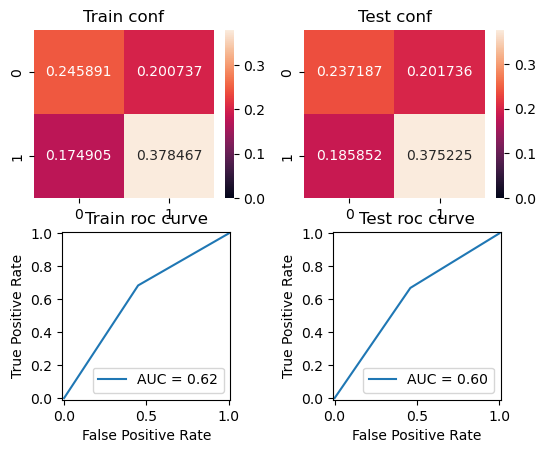

In [ ]:
model = OneRClassifier()
feature_list = lable_encoded_cat_features + one_rule_features
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
pred_test = model.predict(test[feature_list].values)

metrics(
    train[feature_list],
    pred_train,
    pred_train,
    train["target"],
    pred_test,
    pred_test,
    test["target"],
)


## Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

Accurcy             : Train - 0.827 Test - 0.821
F1 score            : Train - 0.841 Test - 0.837
Roc Auc score       : Train - 0.891 Test - 0.887


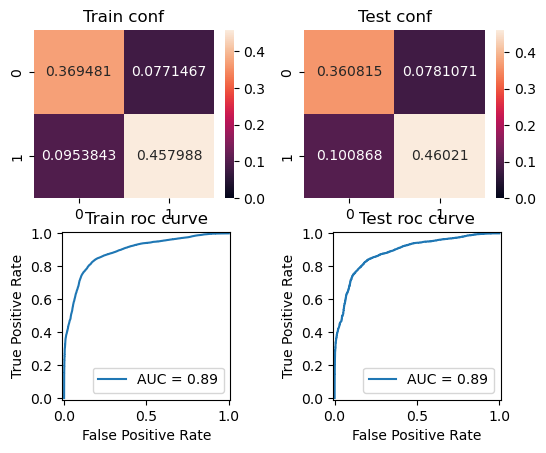

In [ ]:
feature_list = default_ohe_features
model = LogisticRegression(max_iter=5000)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.828 Test - 0.822
F1 score            : Train - 0.841 Test - 0.838
Roc Auc score       : Train - 0.890 Test - 0.886


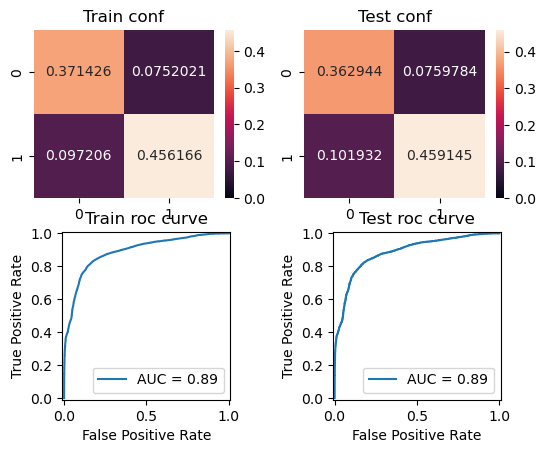

In [ ]:
feature_list = linear_svc_based_features
model = LogisticRegression(max_iter=5000)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Accurcy             : Train - 1.000 Test - 0.999
F1 score            : Train - 1.000 Test - 0.999
Roc Auc score       : Train - 1.000 Test - 1.000


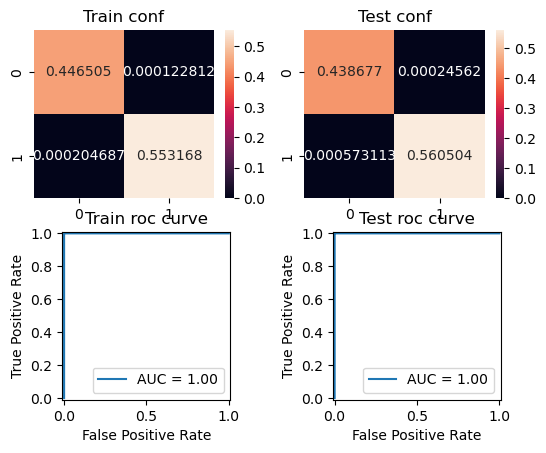

In [ ]:
feature_list = default_ohe_features
model = KNeighborsClassifier()
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 1.000 Test - 1.000
F1 score            : Train - 1.000 Test - 1.000
Roc Auc score       : Train - 1.000 Test - 1.000


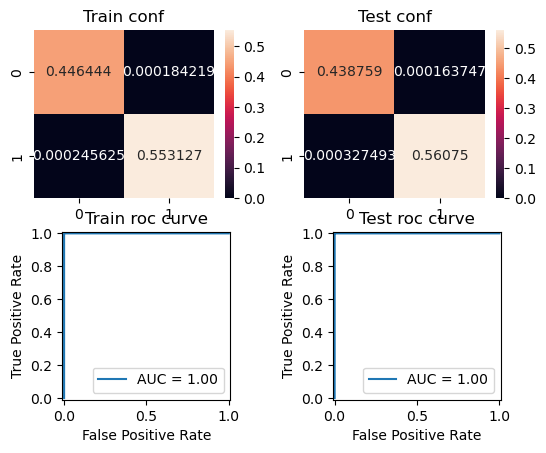

In [ ]:
feature_list = linear_svc_based_features
model = KNeighborsClassifier()
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

## Naive baies

In [ ]:
from sklearn.naive_bayes import MultinomialNB

Accurcy             : Train - 0.728 Test - 0.719
F1 score            : Train - 0.755 Test - 0.750
Roc Auc score       : Train - 0.812 Test - 0.803


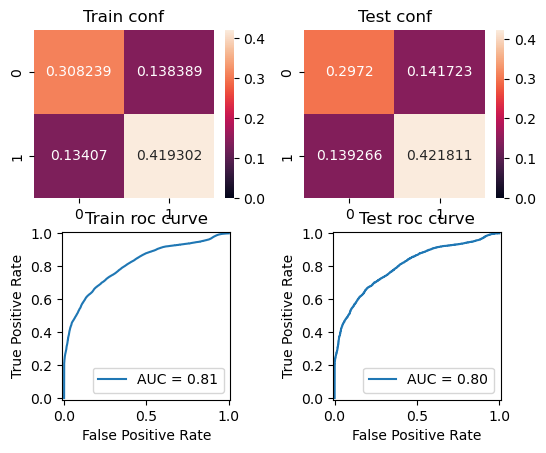

In [ ]:
feature_list = default_ohe_features
model = MultinomialNB()
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.727 Test - 0.718
F1 score            : Train - 0.755 Test - 0.750
Roc Auc score       : Train - 0.811 Test - 0.802


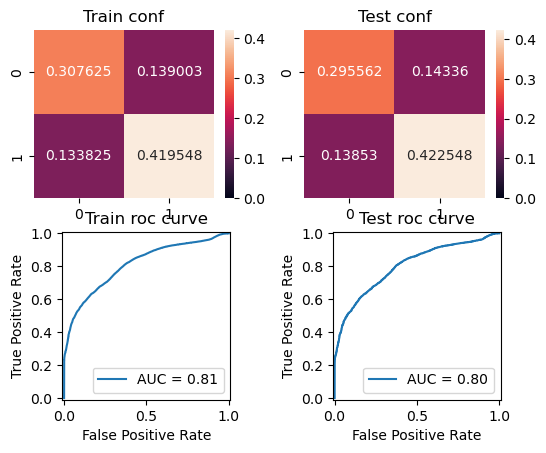

In [ ]:
feature_list = linear_svc_based_features
model = MultinomialNB()
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

## Desicion tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

Accurcy             : Train - 0.974 Test - 0.972
F1 score            : Train - 0.977 Test - 0.975
Roc Auc score       : Train - 0.997 Test - 0.995


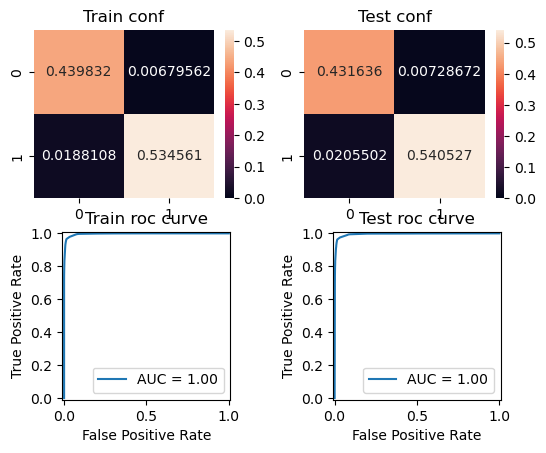

In [ ]:
feature_list = default_le_features
model = DecisionTreeClassifier(max_depth=10)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

Accurcy             : Train - 0.909 Test - 0.904
F1 score            : Train - 0.915 Test - 0.912
Roc Auc score       : Train - 0.978 Test - 0.976


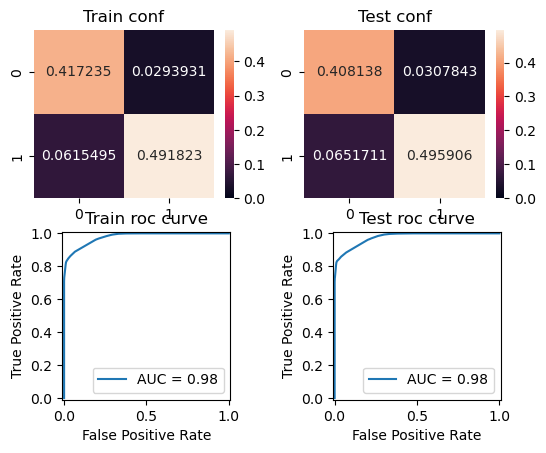

In [ ]:
feature_list = lable_encoded_cat_features
model = DecisionTreeClassifier(max_depth=10)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)


Accurcy             : Train - 0.883 Test - 0.884
F1 score            : Train - 0.897 Test - 0.899
Roc Auc score       : Train - 0.964 Test - 0.965


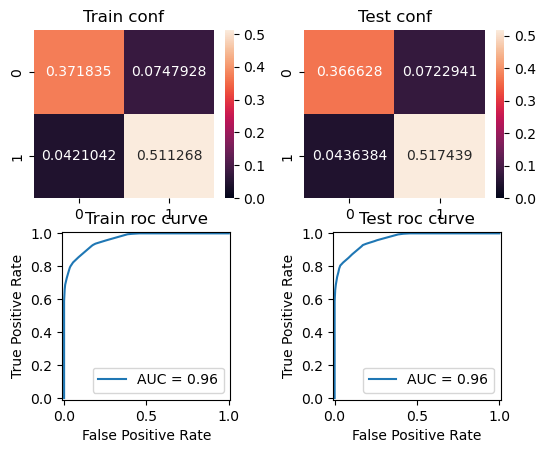

In [ ]:
feature_list = ordere_lable_encoded_cat_features
model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=20)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)


Accurcy             : Train - 0.918 Test - 0.917
F1 score            : Train - 0.928 Test - 0.927
Roc Auc score       : Train - 0.982 Test - 0.980


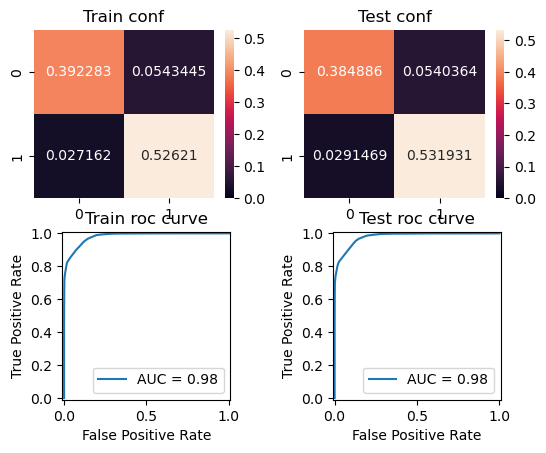

In [ ]:
feature_list = tree_based_features
model = DecisionTreeClassifier(max_depth=8)
model.fit(train[feature_list].values, train["target"].values)
pred_train = model.predict(train[feature_list].values)
proba_train = model.predict_proba(train[feature_list].values)[:, 1]
pred_test = model.predict(test[feature_list].values)
proba_test = model.predict_proba(test[feature_list].values)[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

## Boosting

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
feature_list = real_features + cat_features
catboost_features = list(set(cat_features) & set(feature_list))

t_df = train[feature_list + ["target"]]
test_df = test[feature_list + ["target"]]

t_df.loc[:, catboost_features] = t_df[catboost_features].astype(str)
test_df.loc[:, catboost_features] = test_df[catboost_features].astype(str)

model = CatBoostClassifier(cat_features=catboost_features)
model.fit(t_df[feature_list], t_df["target"].values, silent=True)

pred_train = model.predict(t_df[feature_list])
proba_train = model.predict_proba(t_df[feature_list])[:, 1]
pred_test = model.predict(test_df[feature_list])
proba_test = model.predict_proba(test_df[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

KeyboardInterrupt: 

In [ ]:
feature_list = list(tree_based_features)
catboost_features = list(set(tree_based_features) & set(lable_encoded_cat_features))
t_df = train[feature_list + ["target"]]
test_df = test[feature_list + ["target"]]
t_df.loc[:, catboost_features] = t_df[catboost_features].astype(int)
test_df.loc[:, catboost_features] = test_df[catboost_features].astype(int)
model = CatBoostClassifier(cat_features=catboost_features)
model.fit(t_df[feature_list], t_df["target"].values, silent=True)
pred_train = model.predict(t_df[feature_list])
proba_train = model.predict_proba(t_df[feature_list])[:, 1]
pred_test = model.predict(test_df[feature_list])
proba_test = model.predict_proba(test_df[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)

KeyboardInterrupt: 

## SVC

In [ ]:
from sklearn.svm import LinearSVC

from sklearn.calibration import CalibratedClassifierCV


Accurcy             : Train - 0.824 Test - 0.826
F1 score            : Train - 0.840 Test - 0.842
Roc Auc score       : Train - 0.890 Test - 0.889


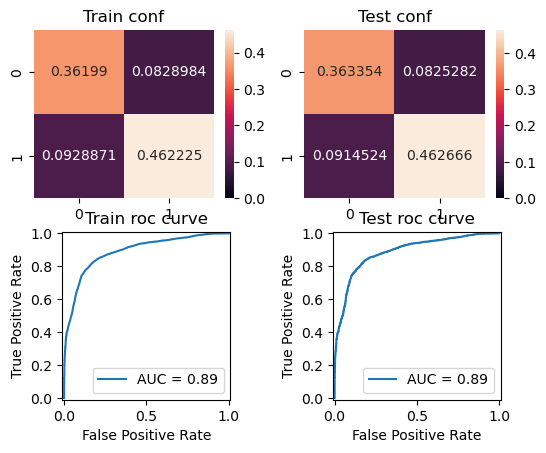

In [ ]:
feature_list = default_ohe_features

model = CalibratedClassifierCV(LinearSVC(dual='auto'))
model.fit(train[feature_list], train["target"].values)
pred_train = model.predict(train[feature_list])
proba_train = model.predict_proba(train[feature_list])[:, 1]
pred_test = model.predict(test[feature_list])
proba_test = model.predict_proba(test[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)


Accurcy             : Train - 0.823 Test - 0.824
F1 score            : Train - 0.839 Test - 0.840
Roc Auc score       : Train - 0.889 Test - 0.888


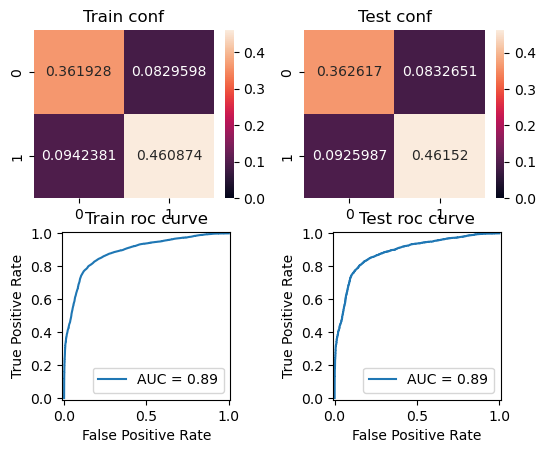

In [ ]:
feature_list = linear_svc_based_features

model = CalibratedClassifierCV(LinearSVC(dual="auto"))
model.fit(train[feature_list], train["target"].values)
pred_train = model.predict(train[feature_list])
proba_train = model.predict_proba(train[feature_list])[:, 1]
pred_test = model.predict(test[feature_list])
proba_test = model.predict_proba(test[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)


## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

Accurcy             : Train - 1.000 Test - 1.000
F1 score            : Train - 1.000 Test - 1.000
Roc Auc score       : Train - 1.000 Test - 1.000


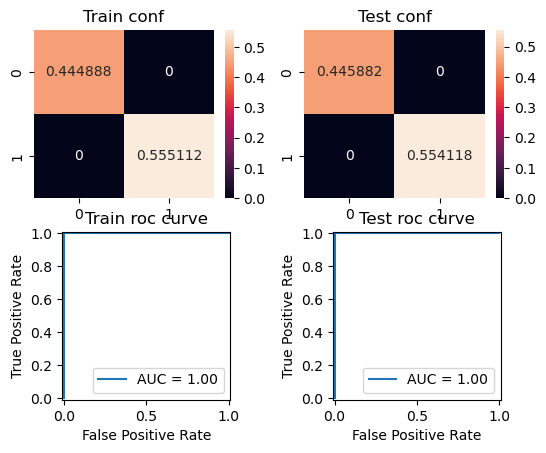

In [ ]:
feature_list = default_ohe_features

model = MLPClassifier()
model.fit(train[feature_list], train["target"].values)
pred_train = model.predict(train[feature_list])
proba_train = model.predict_proba(train[feature_list])[:, 1]
pred_test = model.predict(test[feature_list])
proba_test = model.predict_proba(test[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)


Accurcy             : Train - 1.000 Test - 1.000
F1 score            : Train - 1.000 Test - 1.000
Roc Auc score       : Train - 1.000 Test - 1.000


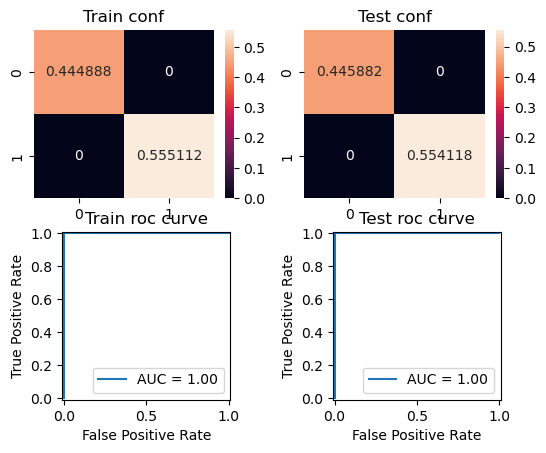

In [ ]:
feature_list = linear_svc_based_features

model = MLPClassifier()
model.fit(train[feature_list], train["target"].values)
pred_train = model.predict(train[feature_list])
proba_train = model.predict_proba(train[feature_list])[:, 1]
pred_test = model.predict(test[feature_list])
proba_test = model.predict_proba(test[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)


## Ensamble

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

Accurcy             : Train - 0.925 Test - 0.924
F1 score            : Train - 0.933 Test - 0.933
Roc Auc score       : Train - 0.977 Test - 0.975


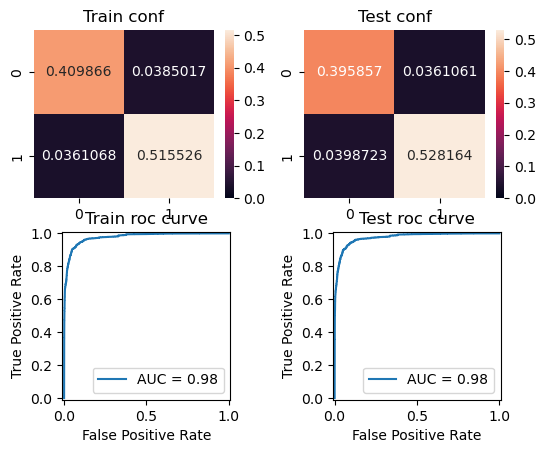

In [ ]:
feature_list = default_le_features

model = GradientBoostingClassifier()
model.fit(train[feature_list], train["target"].values)
pred_train = model.predict(train[feature_list])
proba_train = model.predict_proba(train[feature_list])[:, 1]
pred_test = model.predict(test[feature_list])
proba_test = model.predict_proba(test[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

Accurcy             : Train - 1.000 Test - 1.000
F1 score            : Train - 1.000 Test - 1.000
Roc Auc score       : Train - 1.000 Test - 1.000


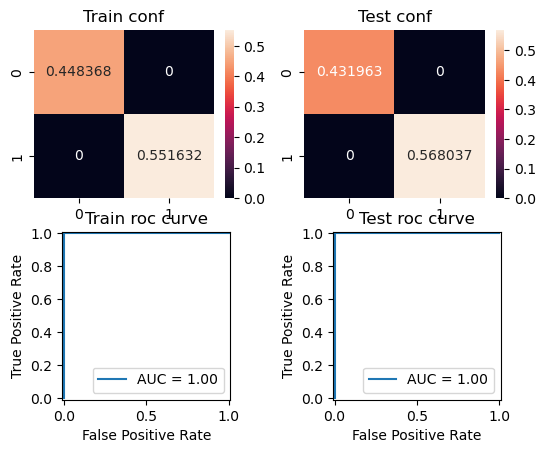

In [ ]:
feature_list = default_le_features

model = RandomForestClassifier()
model.fit(train[feature_list], train["target"].values)
pred_train = model.predict(train[feature_list])
proba_train = model.predict_proba(train[feature_list])[:, 1]
pred_test = model.predict(test[feature_list])
proba_test = model.predict_proba(test[feature_list])[:, 1]

metrics(
    train[feature_list],
    proba_train,
    pred_train,
    train["target"],
    proba_test,
    pred_test,
    test["target"],
)
